In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")
data = pd.read_csv("C:/Users/lenovo/Desktop/乳腺癌诊断数据集/wisc_bc_data.csv")

In [2]:
data.drop("id",axis = 1,inplace=True)
data['diagnosis'] = data['diagnosis'].replace(['M','B'],[1, 0])

In [3]:
columns_to_drop = ["perimeter_mean", "perimeter_se", "perimeter_worst", "area_mean", "area_se", "area_worst", "compactness_mean", "compactness_se", "compactness_worst", "concave points_mean", "concave points_se", "concave points_worst"]
data_new = data.drop(columns_to_drop, axis=1)

In [4]:
y = data_new['diagnosis']
x = data_new.drop(['diagnosis'], axis=1)

In [5]:
def standard_scaler(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    scaled_data = (data - mean) / std
    return scaled_data

In [6]:
x_normalized = standard_scaler(x)
x_normalized = pd.DataFrame(x_normalized, columns=x.columns)
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(x_normalized.values, y.values, test_size=0.2, random_state=421)

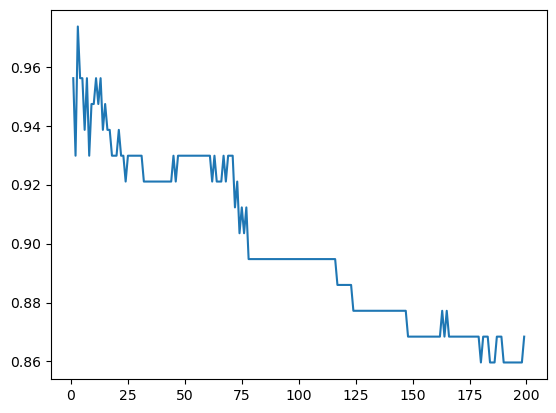

<Figure size 1200x900 with 0 Axes>

In [7]:
score = []
krange = range(1, 200)

for i in krange:
    clf = KNeighborsClassifier(n_neighbors=i)
    clf = clf.fit(xtrain, ytrain)
    score.append(clf.score(xtest, ytest))

plt.plot(krange, score)
plt.figure(figsize=(12, 9))
plt.show()

In [8]:
def confusion_matrix(y_true, y_pred, labels):
    num_labels = len(labels)
    matrix = [[0] * num_labels for _ in range(num_labels)]
    for true_label, pred_label in zip(y_true, y_pred):
        matrix[true_label][pred_label] += 1
    return matrix

In [9]:
k_best=score.index(max(score))+1
clf = KNeighborsClassifier(n_neighbors=k_best)
clf.fit(xtrain,ytrain)
y_pred = clf.predict(xtest)
cm = confusion_matrix(ytest, y_pred,['1','0'])

print("混淆矩阵：")
print(cm)
print(clf.score(xtest,ytest))

混淆矩阵：
[[71, 1], [2, 40]]
0.9736842105263158


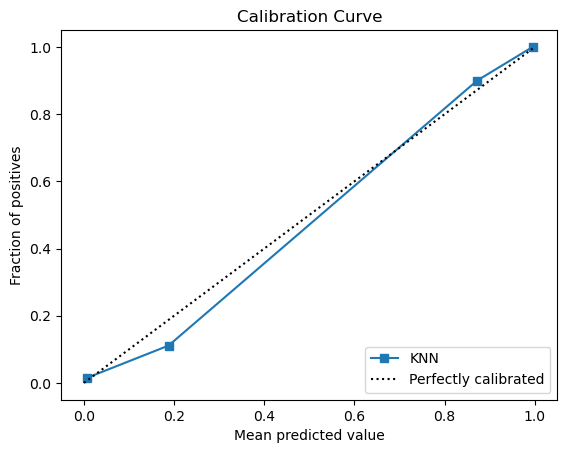

In [10]:
probabilities = clf.predict_proba(xtest)
calibrated_clf = CalibratedClassifierCV(clf, cv='prefit')
calibrated_clf.fit(xtrain, ytrain)
calibrated_probabilities = calibrated_clf.predict_proba(xtest)
uncalibrated_score = brier_score_loss(ytest, probabilities[:, 1])
calibrated_score = brier_score_loss(ytest, calibrated_probabilities[:, 1])
fraction_of_positives, mean_predicted_value = calibration_curve(ytest, calibrated_probabilities[:, 1], n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="KNN")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title("Calibration Curve")
plt.show()

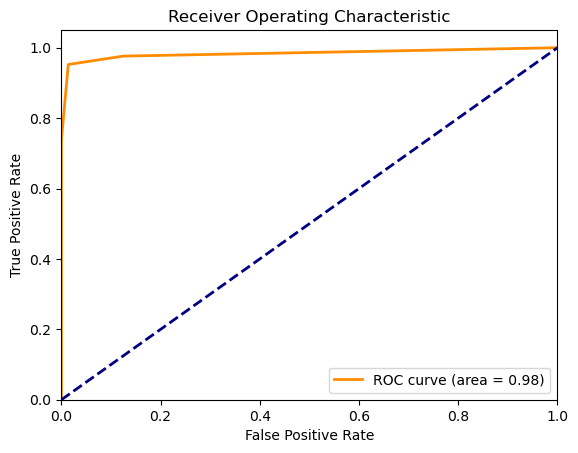

In [11]:
y_pred_proba = clf.predict_proba(xtest)[:, 1]
fpr, tpr, thresholds = roc_curve(ytest, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [12]:
from collections import Counter  # 为了做投票

def euc_dis(instance1, instance2):
    """
    计算两个样本instance1和instance2之间的欧式距离
    instance1: 第一个样本， array型
    instance2: 第二个样本， array型
    """
    # TODO
    dist = np.sqrt(np.sum((instance1-instance2)**2))
    return dist


def knn_classify(X, y, testInstance, k):
    """
    给定一个测试数据testInstance, 通过KNN算法来预测它的标签。 
    X: 训练数据的特征
    y: 训练数据的标签
    testInstance: 测试数据，这里假定一个测试数据 array型
    k: 选择多少个neighbors? 
    """
    # TODO  返回testInstance的预测标签 = {0,1,2}

    # 计算 testInstance 与 X的距离
    dists = [euc_dis(x, testInstance) for x in X]

    # 找出最近的K个元素的idx
    idxknn = np.argsort(dists)[:k]  # 将dists从小到大排序，返回排序后的元素indices

    # 找出KNN对应的n个y值
    yknn = y[idxknn]

    # 返回投票结果
    return Counter(yknn).most_common(1)[0][0]


predictions = [knn_classify(xtrain, ytrain, data, k_best) for data in xtest]
correct = np.count_nonzero((predictions == ytest) == True)

# 计算混淆矩阵
cm = confusion_matrix(ytest, predictions,['1','0'])

print("混淆矩阵：")
print(cm)
print("Accuracy is: %.4f" % (correct/len(xtest)))

混淆矩阵：
[[71, 1], [2, 40]]
Accuracy is: 0.9737
